In [63]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import seaborn as sb
import matplotlib.pyplot as plt

import sys
import os
sys.path.insert(0, os.path.abspath('../../modules'))

from helper_functions import feature_reduction_decision_tree, feature_reduction_x, count_nan_features, heatmap

from datetime import datetime

In [40]:
balanced_dataset = '../../data/training/ber-rating-dataset-final-split_0.csv' # 1st split of balanced dataset
balanced_dataset_1 = '../../data/training/ber-rating-dataset-final-split_1.csv' # 1st split of balanced dataset
balanced_dataset_2 = '../../data/training/ber-rating-dataset-final-split_2.csv' # 2nd split of balanced dataset

df = pd.read_table(balanced_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
df_1 = pd.read_table(balanced_dataset_1, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
df_2 = pd.read_table(balanced_dataset_2, sep=";", encoding='cp437', header=0, on_bad_lines="warn")

df = pd.concat([df, df_2, df_1], ignore_index=True, sort=False)

print(df.shape)

/var/folders/nj/kdpjd7j978g0r39qfsf_wr480000gn/T/ipykernel_33661/3636867610.py:6: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_table(balanced_dataset_1, sep=";", encoding='cp437', header=0, on_bad_lines="warn")
/var/folders/nj/kdpjd7j978g0r39qfsf_wr480000gn/T/ipykernel_33661/3636867610.py:7: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2 = pd.read_table(balanced_dataset_2, sep=";", encoding='cp437', header=0, on_bad_lines="warn")


(82883, 212)


In [41]:
df.head()

,index,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,5640,Dublin 20,Semi-detached house,1969,Existing,F,403.64,116.82,1.96,0.65,...,NaN,NaN,268037012,0.050000,0.050000,0.000,46510.4,0.00,2.369,2.630
1,13237,Co. Meath,Detached house,1979,Existing,A3,63.37,167.87,0.17,0.13,...,NaN,NaN,167050001,0.050000,0.050000,0.481,18939.2,9863.61,0.711,0.403
2,14229,Co. Dublin,Semi-detached house,1986,Existing,B2,106.61,107.02,0.60,0.32,...,NaN,NaN,267134021,0.000222,0.012347,0.289,12788.9,4641.45,0.681,0.704
3,17232,Co. Wexford,Detached house,1880,Existing,D2,298.69,123.76,1.62,0.25,...,NaN,NaN,247109003/247109004,0.050000,0.050000,0.000,36220.3,0.00,2.046,1.683
4,17096,Co. Longford,Detached house,1982,Existing,C2,196.09,113.09,0.60,0.16,...,NaN,NaN,137045007,0.050000,0.050000,0.207,24747.5,5503.68,1.430,1.135


In [42]:
df.describe()

,index,Year_of_Construction,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,WallArea,...,ThirdWallUValue,ThirdWallAgeBandId,ThirdWallTypeId,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
count,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,82883.000000,...,17251.000000,17171.000000,17244.000000,7.243700e+04,72437.000000,73588.000000,73588.000000,73588.000000,76634.000000,76634.000000
mean,9722.396064,1979.050638,218.725316,123.369276,0.784057,0.486241,0.453512,2.434389,2.241652,104.559919,...,0.846200,6.465552,7.292044,3.767559e-02,0.038505,0.164638,24034.303297,2891.381878,1.417738,1.268859
std,5704.284985,38.995865,176.153619,69.376423,0.653652,0.618796,0.266404,0.938313,1.042583,62.235812,...,0.643403,3.151618,2.964806,3.119741e-02,0.023137,0.260090,19371.217813,5537.934783,1.234242,0.915512
min,0.000000,1753.000000,-472.990000,8.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050000,0.000000,1.000000,6.900000e-09,0.002500,0.000000,0.000000,-14290.200000,-3.025000,-2.947000
25%,4797.500000,1962.000000,95.520000,78.750000,0.300000,0.130000,0.250000,1.860000,1.400000,60.990000,...,0.339000,4.000000,4.000000,2.500000e-03,0.012347,0.000000,11123.250000,0.000000,0.627000,0.607000
50%,9656.000000,1991.000000,188.400000,106.510000,0.550000,0.250000,0.440000,2.470000,2.940000,93.470000,...,0.550000,7.000000,8.000000,5.000000e-02,0.050000,0.000000,20839.050000,0.000000,1.192000,1.143000
75%,14542.000000,2005.000000,310.815000,148.414500,1.130000,0.450000,0.640000,2.950000,3.000000,132.000000,...,1.377000,9.000000,10.000000,5.000000e-02,0.050000,0.297000,32089.225000,4961.600000,1.914000,1.735000
max,19999.000000,2024.000000,11476.290000,1190.840000,3.260000,7.000000,4.970000,8.340000,6.990000,861.910000,...,10.000000,11.000000,14.000000,8.300218e-01,0.304762,6.296000,382032.000000,519638.000000,14.008000,8.909000


In [43]:
X = feature_reduction_x(df)

/Users/igor/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 55 111 112 113 119 120 121] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/igor/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [54]:
y = df.EnergyRating
#y = df.BerRating
print(X.shape)
print(y.shape)

(82883, 100)
(82883,)


In [55]:
X_1 = pd.get_dummies(X)

feature_names = X_1.columns
X_1.head()

,Year_of_Construction,GroundFloorArea(sq m),UValueWall,UValueRoof,UValueFloor,UValueWindow,UvalueDoor,WallArea,RoofArea,FloorArea,...,CylinderStat_YES,CombinedCylinder_YES,ThermalMassCategory_High,ThermalMassCategory_Low,FirstEnergyType_Description_Renewable Electrical,FirstEnergyType_Description_Renewable Thermal,FirstWallType_Description_Other,FirstWallType_Description_Stone,FirstWallType_Description_Timber Frame,FirstWallDescription_KTF Timber Frame
0,0.797048,0.091354,0.601227,0.092857,0.162978,0.407674,0.244635,0.114792,0.076761,0.086831,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.833948,0.134543,0.052147,0.018571,0.114688,0.109113,0.144492,0.152638,0.194608,0.227898,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.859779,0.083063,0.184049,0.045714,0.106640,0.296163,0.244635,0.092968,0.070286,0.084320,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.468635,0.097225,0.496933,0.035714,0.110664,0.239808,0.000000,0.119722,0.142834,0.168015,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.845018,0.088198,0.184049,0.022857,0.114688,0.407674,0.429185,0.114211,0.130520,0.153530,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [57]:
X_train, X_test, y_train, y_test = train_test_split( X_1, y, stratify=y, random_state=2)

In [58]:
print("Start Time:", datetime.now())
for d in range(2,15):
    model = DecisionTreeClassifier(max_depth=d)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Depth:", d, "Accuracy:", scores.mean(), "Time:", datetime.now())

Start Time: 2024-04-14 17:32:51.642539
Depth: 2 Accuracy: 0.23443574418600557 Time: 2024-04-14 17:32:53.274558
Depth: 3 Accuracy: 0.2955985200365076 Time: 2024-04-14 17:32:55.444198
Depth: 4 Accuracy: 0.33670082064576556 Time: 2024-04-14 17:32:58.144518
Depth: 5 Accuracy: 0.371770516221775 Time: 2024-04-14 17:33:01.524469
Depth: 6 Accuracy: 0.3929248623328893 Time: 2024-04-14 17:33:05.474064
Depth: 7 Accuracy: 0.41404714339645565 Time: 2024-04-14 17:33:09.923915
Depth: 8 Accuracy: 0.4299411615887929 Time: 2024-04-14 17:33:15.002778
Depth: 9 Accuracy: 0.4451756006790994 Time: 2024-04-14 17:33:20.579307
Depth: 10 Accuracy: 0.459284004218855 Time: 2024-04-14 17:33:26.765735
Depth: 11 Accuracy: 0.47414827775460766 Time: 2024-04-14 17:33:33.502624
Depth: 12 Accuracy: 0.4837843841704535 Time: 2024-04-14 17:33:41.009063
Depth: 13 Accuracy: 0.4883690959346473 Time: 2024-04-14 17:33:49.076893
Depth: 14 Accuracy: 0.4914096183600728 Time: 2024-04-14 17:33:58.227362


In [59]:
model = DecisionTreeClassifier(max_depth=14)
model.fit(X_train,y_train)


print("Training Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

Training Accuracy: 0.7174640455583797
Test Accuracy: 0.5013754162443897


In [61]:
def heatmap2(cm):
  labels = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3", "D1", "D2", "E1", "E2", "F", "G"]
  cm_df =  pd.DataFrame(cm, labels, labels)
  cm_percent =  cm_df.copy().apply(lambda x: x/x.sum(), axis=1)
  plt.figure(figsize=(12, 10))
  ax = sb.heatmap(cm_percent, annot=cm_df, fmt=f".0f", cmap="Blues", cbar=False, vmin=0, vmax=1)
  ax.set(xlabel="Predicted Category", ylabel="True Category")
  #cbar = ax.figure.colorbar(ax.collections[0])
  cbar = ax.figure.colorbar(ax.collections[0])
  cbar.set_ticks([0, 1])
  cbar.set_ticklabels(["0%", "100%"])
  plt.show()

CM


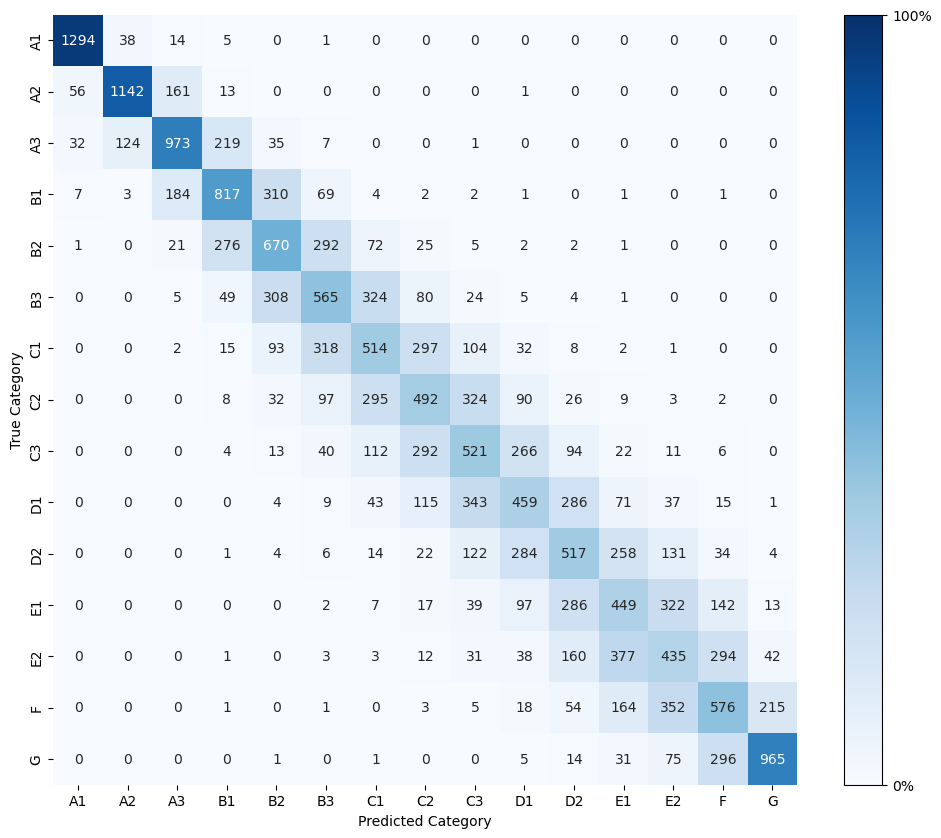

In [64]:
y_hat = model.predict(X_test)
cm = confusion_matrix(y_test, y_hat)

print("CM")
#print(cm)
heatmap2(cm)

In [68]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

          A1       0.93      0.96      0.94      1352
          A2       0.87      0.83      0.85      1373
          A3       0.72      0.70      0.71      1391
          B1       0.58      0.58      0.58      1401
          B2       0.46      0.49      0.47      1367
          B3       0.40      0.41      0.41      1365
          C1       0.37      0.37      0.37      1386
          C2       0.36      0.36      0.36      1378
          C3       0.34      0.38      0.36      1381
          D1       0.35      0.33      0.34      1383
          D2       0.36      0.37      0.36      1397
          E1       0.32      0.33      0.33      1374
          E2       0.32      0.31      0.31      1396
          F        0.42      0.41      0.42      1389
          G        0.78      0.70      0.73      1388

    accuracy                           0.50     20721
   macro avg       0.51      0.50      0.50     20721
weighted avg       0.50   

In [ ]:
dot_data = StringIO()
target_names = ["A3", "C1", "A2", "C2", "B3", "C3", "D1", "D2", "B2", "G", "E1", "B1", "F", "E2", "A1"]
export_graphviz(model, 
                out_file=dot_data,
                filled=True, 
                rounded=True,
                special_characters=True,
                feature_names = feature_names, 
                class_names = target_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('BER_DecisionTree.png')
Image(graph.create_png())